In [18]:
# Verificar o exemplo abaixo:
# https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-whale-tails.ipynb

import numpy as np
import os
import cv2
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available 1


In [19]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = 256
epochs = 50
validation_split= 0.2
batch_size=8

#path_carregar_pesos = '.\\result_100epochs_256input_5filtros\\result.h5'
path_carregar_pesos = ''

#f = [16, 32, 64, 128, 256] # configuração original

#f = [16, 32, 64, 128, 256] # Teste 01
#f = [16, 32, 64, 128] # Teste 02
#f = [16, 32, 64] # Teste 03
#f = [16, 32] # Teste 04
#f = [16] # Teste 05
#f = [16, 16] # Teste 06
#f = [16, 16, 16] # Teste 07
#f = [16, 16, 16, 16] # Teste 08
f = [16, 16, 16, 16, 16] # Teste 09
#f = [32] # Teste 10
#f = [64] # Teste 11
#f = [128] # Teste 12

base_treino = 'E'
base_output_path = '.\\Teste_09' + base_treino

print("Configurações carregadas")

Configurações carregadas


In [20]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


inputs = keras.layers.Input((image_size, image_size, 3))
p0 = inputs
down_blocks_layers = [{
    "p": p0
}]
for i in range(len(f) -1 ):
    c, p = down_block(down_blocks_layers[i]["p"], f[i])
    down_blocks_layers.append({
        "c": c,
        "p": p
    })
    

bn = bottleneck(down_blocks_layers[len(down_blocks_layers)-1]["p"], f[len(f)-1])
up_blocks_layers = [bn]

for i in range(len(f) -1 ):
    invertI = len(f) - i  - 1
    p = up_block(up_blocks_layers[i],down_blocks_layers[invertI]["c"], f[invertI])
    up_blocks_layers.append(p)

outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up_blocks_layers[len(up_blocks_layers) - 1])
model = keras.models.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()
    
print("Modelo criado!")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_23[0][0]                  
____________________________________________________________________________________________

In [ ]:
def loadImgs(path_list, mode):
    imgs = []
    nomes = []
    for path in path_list:
        files = os.listdir(path)
        files.sort()
        print("path:", path, " file", len(files))
        for file in files:
            imgPath = os.path.join(path, file)
            print("loanding img:",len(imgs), imgPath)
            img = cv2.imread(imgPath, mode)
            if mode == 0:
                 img = np.expand_dims(img, 2)
            img = img / float(255)
            imgs.append(img)
            nomes.append(file)
            
    return np.array(imgs),nomes

# Load images
# trainImgs,nomes = loadImgs(['./Recortes/Base_A/'], 1)
# validImgs,nomes = loadImgs(['./Recortes/Base_A_mask/'], 0)

trainImgs,nomes = loadImgs(['./Recortes/Base_'+base_treino+'/'], 1)
validImgs,nomes = loadImgs(['./Recortes/Base_'+base_treino+'_mask/'], 0)

print("Imagens carregadas")


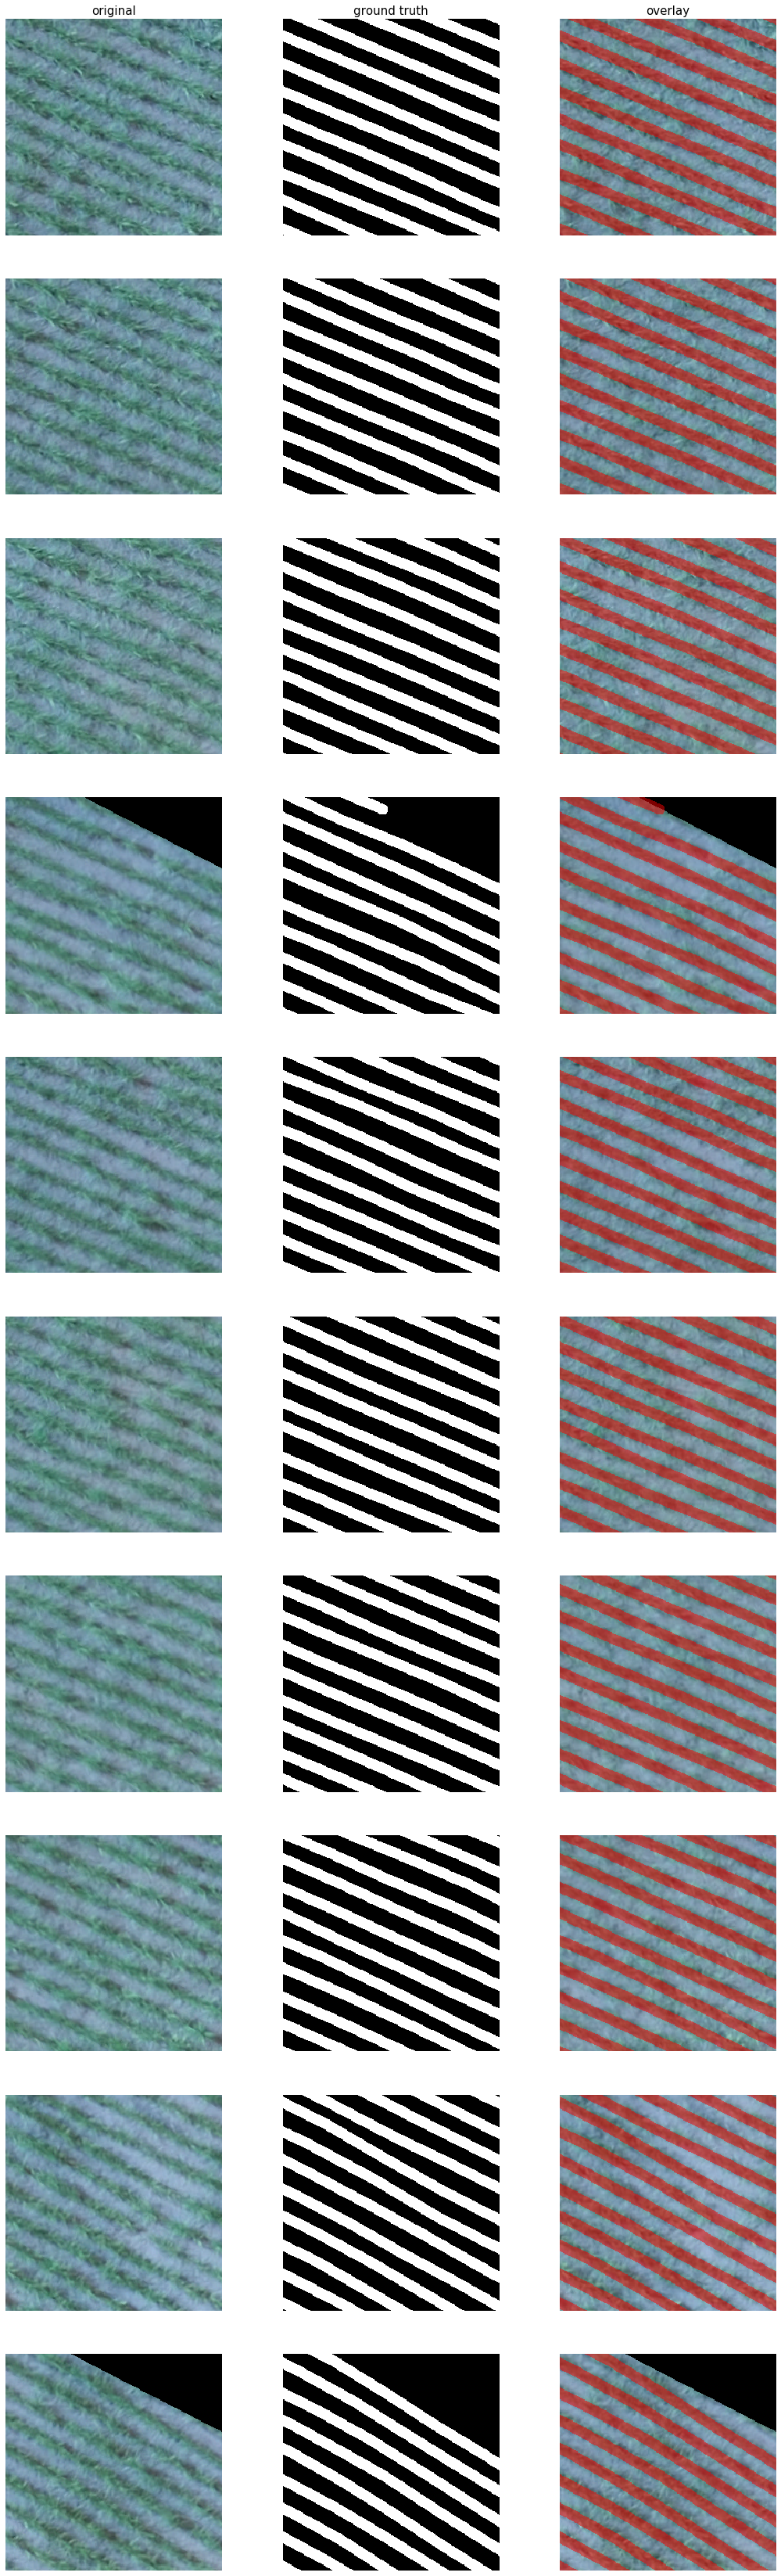

In [22]:
MASK_COLORS = [
    "red", "green", "blue",
    "yellow", "magenta", "cyan"
]

def mask_to_rgba(mask, color="red"):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    
    Args:
        mask (numpy.ndarray): [description]
        color (str, optional): Check `MASK_COLORS` for available colors. Defaults to "red".
    
    Returns:
        numpy.ndarray: [description]
    """    
    assert(color in MASK_COLORS)
    assert(mask.ndim==3 or mask.ndim==2)

    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = mask.reshape(h, w)
    if color == "red":
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == "green":
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == "yellow":
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == "magenta":
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, ones, ones, ones), axis=-1)
    
def get_cmap(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        string: [description]
    """
    if arr.ndim == 3:
        return "gray"
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return "jet"
        elif arr.shape[3] == 1:
            return "gray"

def zero_pad_mask(mask, desired_size):
    """[summary]
    
    Args:
        mask (numpy.ndarray): [description]
        desired_size ([type]): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask

def reshape_arr(arr):
    """[summary]
    
    Args:
        arr (numpy.ndarray): [description]
    
    Returns:
        numpy.ndarray: [description]
    """
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])
        
def plot_imgs(
        org_imgs,
        mask_imgs,
        pred_imgs=None,
        nm_img_to_plot=10,
        figsize=4,
        alpha=0.5,
        color="red"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize), squeeze=False
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(
                mask_to_rgba(
                    zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(pred_imgs),
                alpha=alpha,
            )
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(
                mask_to_rgba(
                    zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()
    
plot_imgs(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=10, figsize=6)

In [23]:
if(path_carregar_pesos == ''):
    history = model.fit(trainImgs, validImgs, epochs=epochs,  batch_size=batch_size, validation_split=validation_split)
    print('Modelo treinado')
else:
    model.load_weights(path_carregar_pesos)
    print('Pesos carregados')
    

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 24s 15ms/sample - loss: 0.3920 - acc: 0.8094 - val_loss: 0.4148 - val_acc: 0.8286
Epoch 2/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.2303 - acc: 0.9029 - val_loss: 0.3103 - val_acc: 0.8633
Epoch 3/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.1967 - acc: 0.9173 - val_loss: 0.2771 - val_acc: 0.8817
Epoch 4/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.1858 - acc: 0.9223 - val_loss: 0.2798 - val_acc: 0.8780
Epoch 5/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.1832 - acc: 0.9233 - val_loss: 0.2903 - val_acc: 0.8806
Epoch 6/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.1730 - acc: 0.9273 - val_loss: 0.2703 - val_acc: 0.8836los - ETA: 0s - loss: 0.1733 - acc: 0.
Epoch 7/50
1600/1600 [==============================] - 22s 14ms/sample - loss: 0.1695 

In [24]:
class ModelSaver:
    def __init__(self, history, base_output_path):
        self.history = history
        self.base_output_path = base_output_path
        try:
            os.mkdir(base_output_path)
        except OSError as error:
            print(error) 
        
    def saveModel(self, model):
        fileName = os.path.join(self.base_output_path,"result.h5")
        model.save(fileName)
        print("saved to:", fileName)
        
    def plotAndSaveMetrics(self, metric_name, show_val):
        plt.plot(self.history.history[str(metric_name)])
        if show_val:
            plt.plot(self.history.history['val_'+str(metric_name)])
        plt.title("Acurácia por épocas")
        plt.xlabel("épocas")
        plt.legend(['treino','validação'])
        output_path =  os.path.join(self.base_output_path,"acc_por_epocas")
        plt.savefig(output_path)
        print("saved to:", output_path)
    
    def plotAndSaveLoss(self, show_val):
        plt.plot(self.history.history['loss'])
        if show_val:
             plt.plot(self.history.history['val_loss'])
        plt.title("Perda por épocas")
        plt.xlabel("épocas")
        plt.legend(['treino','validação'])
        output_path = os.path.join(self.base_output_path,"loss_por_epocas")
        print("saved to:", output_path)
        plt.savefig(output_path)
        
        
    def predictAndSave(self, model, imgs, nomes_imgs, images_to_show):
        predict_imgs = model.predict(imgs)
        
        plot_imgs(org_imgs=imgs, mask_imgs=predict_imgs, nm_img_to_plot=10, figsize=6)
             
        base_output_result_img = os.path.join(self.base_output_path,"result-images")
        if(os.path.isdir(base_output_result_img) == False):
            try:
                os.mkdir(base_output_result_img)
            except OSError as error:
                print(error) 
        
        for i in range(len(nomes_imgs)):
            file_name = nomes_imgs[i].replace(".jpg", ".png")
            file_name = file_name.replace(".jpg", ".png")
            output_path = os.path.join(base_output_result_img , file_name)
            print("writing img:",i," to", output_path)
            cv2.imwrite(output_path, predict_imgs[i] * 255.0)

    def saveHistory(self):
        output_path = os.path.join(self.base_output_path,"history.csv")
        # convert the history.history dict to a pandas DataFrame:     
        hist_df = pd.DataFrame(history.history) 
        # or save to csv: 
        #hist_csv_file = 'history.csv'
        with open(output_path, mode='w') as f:
            hist_df.to_csv(f)
        
        print("saved to:", output_path)

modelSaver = ModelSaver(history, base_output_path)

print('ModelSaver criado!')

ModelSaver criado!


saved to: .\Teste_09E\acc_por_epocas


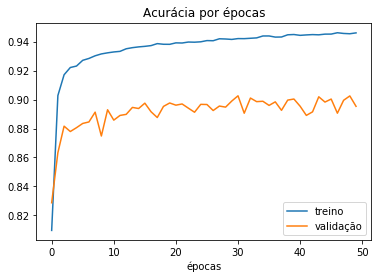

In [25]:
modelSaver.plotAndSaveMetrics("acc", True)
#modelSaver.plotAndSaveMetrics("mean_io_u", True)

saved to: .\Teste_09E\loss_por_epocas


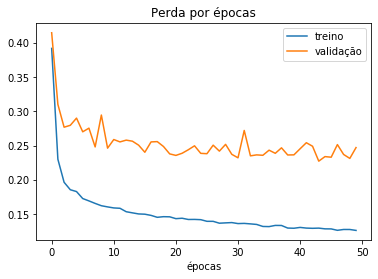

In [26]:
modelSaver.plotAndSaveLoss(True)

In [27]:
modelSaver.saveModel(model)
modelSaver.saveHistory()

saved to: .\Teste_09E\result.h5
saved to: .\Teste_09E\history.csv


In [ ]:
avaliaImgs,avaliaImgsNomes = loadImgs(['./Recortes/Base_A/'], 1)
print(len(avaliaImgs))
modelSaver.predictAndSave(model, avaliaImgs, avaliaImgsNomes, 5)

In [ ]:
avaliaImgs,avaliaImgsNomes = loadImgs(['./Recortes/Base_B/'], 1)
print(len(avaliaImgs))
modelSaver.predictAndSave(model, avaliaImgs, avaliaImgsNomes, 5)

In [ ]:
avaliaImgs,avaliaImgsNomes = loadImgs(['./Recortes/Base_C/'], 1)
print(len(avaliaImgs))
modelSaver.predictAndSave(model, avaliaImgs, avaliaImgsNomes, 5)

In [ ]:
avaliaImgs,avaliaImgsNomes = loadImgs(['./Recortes/Base_D/'], 1)
print(len(avaliaImgs))
modelSaver.predictAndSave(model, avaliaImgs, avaliaImgsNomes, 5)